**Задача** состоит в том, чтобы создать алгоритмы для «отслеживания знаний», то есть моделирования знаний учащихся с течением времени, смогут ли студенты правильно ответить на свои следующие вопросы. **Цель** состоит в том, чтобы точно предсказать, как учащиеся будут выполнять свои обязанности в будущем.
<br> В случае успеха любой учащийся, подключенный к Интернету, может воспользоваться преимуществами индивидуального обучения, независимо от того, где он живет.

<br>Это соревнование по кодам временных рядов, данные получаются из тестового набора и затем делаются прогнозы с помощью API временных рядов Kaggle.

Представленные данные (submission) оцениваются по площади под кривой ROC (**ROC-AUC**) между прогнозируемой **вероятностью** и наблюдаемой целью.

Отправка ответов (submission) должна производиться из ядра kaggle.
<br>Среда ядра автоматически форматирует и создает ваши файлы (submission) для участия в этом конкурсе. Нет необходимости создавать свои материалы вручную.

Заявки (submissions) на участие в этом конкурсе должны быть сделаны через блокноты (notebooks).
<br>CPU Notebook <= 9 часов время выполнения
<br>GPU Notebook <= 9 часов время выполнения
<br>TPU Notebook <= 3 часов время выполнения

Разрешены свободно и общедоступные внешние данные, включая предварительно обученные модели.
<br>Submission file must be named submission.csv

---

**train.csv**:

* ROW_ID: (int64) ID code for the row.

* TIMESTAMP: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

* USER_ID: (int32) ID code for the user.

* CONTENT_ID: (int16) ID code for the user interaction

* CONTENT_TYPE_ID: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

* TASK_CONTAINER_ID: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

* USER_ANSWER: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

* ANSWERED_CORRECTLY: (int8) if the user responded correctly. Read -1 as null, for lectures.

* PRIOR_QUESTION_ELAPSED_TIME: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

* PRIOR_QUESTION_HAD_EXPLANATION: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

---

### Explotary data analysis. Stage 1.

In [1]:
import numpy as np
import pandas as pd
import time

from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

In [2]:
%%time

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

data = pd.read_csv(r"\Data\train.csv", 
                   dtype=dtypes)

Wall time: 2min 27s


In [3]:
bold('**Shape of our train data:**')
display(data.shape)

**Shape of our train data:**

(101230332, 10)

In [4]:
bold('**Data information:**')
display(data.info())

**Data information:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


None

In [5]:
bold('**Memory usage by data:**')
display(data.memory_usage(deep=True))

**Memory usage by data:**

Index                                   128
row_id                            809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   202460664
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

In [6]:
data.head(10)

row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692            False                  1   
1       1      56943      115        5716            False                  2   
2       2     118363      115         128            False                  0   
3       3     131167      115        7860            False                  3   
4       4     137965      115        7922            False                  4   
5       5     157063      115         156            False                  5   
6       6     176092      115          51            False                  6   
7       7     194190      115          50            False                  7   
8       8     212463      115        7896            False                  8   
9       9     230983      115        7863            False                  9   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   
5            2                   1                       5000.0   
6            0                   1                      17000.0   
7            3                   1                      17000.0   
8            2                   1                      16000.0   
9            0                   1                      16000.0   

   prior_question_had_explanation  
0                            <NA>  
1                           False  
2                           False  
3                           False  
4                           False  
5                           False  
6                           False  
7                           False  
8                           False  
9                           False

- row_id нужно убрать
- временной ряд относительно timestamp
- на одного юзера выделяется довольно много строк (на 1го -- 45) 
- значения task_container_id монотонно не убывают, но присутствуют 0 (проверить, должно ли так быть)
- prior_question_had_explanation перевести в bool
- присутствуют NaN, NA в посл 2х столбцах

In [7]:
data = data.drop('row_id', 1)
data['prior_question_had_explanation'] = data['prior_question_had_explanation'].astype('boolean')

bold('**Memory usage by data:**')
display(data.memory_usage(deep=True))

data.head()

**Memory usage by data:**

Index                                   128
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   202460664
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

timestamp  user_id  content_id  content_type_id  task_container_id  \
0          0      115        5692            False                  1   
1      56943      115        5716            False                  2   
2     118363      115         128            False                  0   
3     131167      115        7860            False                  3   
4     137965      115        7922            False                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

   prior_question_had_explanation  
0                            <NA>  
1                           False  
2                           False  
3                           False  
4                           False

* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture <br>-- нужно False/True $\rightarrow$ 0/1.
* task_container_id: (int16) Id code for the batch of questions or lectures.

* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
<br>ВОЗМОЖНО, эти два столбца нужно перекодировать, чтобы -1 не учитывалось как-то в моделях.
<br>Мб убрать эти строчки для моделей, все-таки если ответов нет, то и зачем их учитывать.
<br>Мб разбить на лекции и вопросы.

In [8]:
bold('**Number of unique students:**')
display(
        len(
            np.unique(data['user_id'])
        )
)

**Number of unique students:**

393656

In [9]:
bold('**Number of unique contents:**')
display(
        len(
            np.unique(data['content_id'])
        )
)

**Number of unique contents:**

13782

In [10]:
bold('**Number of questions in content ids:**')
display(
        data[data['content_type_id'] == False]['content_id']. \
                                                             nunique()
)

**Number of questions in content ids:**

13523

```Content_type_id = False``` means that a question was asked. True means that the user was watching a lecture:

In [11]:
bold('**Number of unique contents:**')
display(
        len(
            np.unique(data['content_id'])
        )
)

**Number of unique contents:**

13782

In [12]:
bold('**Lectures & questions:**')
display(
        data['content_type_id'].value_counts()
)

**Lectures & questions:**

False    99271300
True      1959032
Name: content_type_id, dtype: Int64

In [13]:
bold("**Columns with gaps:**")
display(
        data.isna().any()
)

**Columns with gaps:**

timestamp                         False
user_id                           False
content_id                        False
content_type_id                   False
task_container_id                 False
user_answer                       False
answered_correctly                False
prior_question_elapsed_time        True
prior_question_had_explanation     True
dtype: bool

In [14]:
bold("**Percentage of missing values for every column:**")
display(
        data.isnull().sum() / len(data) * 100
)

**Percentage of missing values for every column:**

timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       2.322958
prior_question_had_explanation    0.387736
dtype: float64

In [15]:
bold("**User answers for every option:**")
display(
        data['user_answer'].value_counts()
)

**User answers for every option:**

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

In [16]:
bold("**Questions answered correctly:**")
display(
        data['answered_correctly'].value_counts()
)

**Questions answered correctly:**

 1    65244627
 0    34026673
-1     1959032
Name: answered_correctly, dtype: int64

In [17]:
user_percent = data[data['answered_correctly'] != -1]. \
                                                      groupby('user_id')['answered_correctly']. \
                                                      agg(mean = 'mean', 
                                                          answers = 'count')

bold("**The highest number of questions answered by a user is**")
display(
        user_percent['answers'].max()
)

**The highest number of questions answered by a user is**

17609

In [18]:
content_percent = data[data['answered_correctly'] != -1]. \
                                                         groupby('content_id')['answered_correctly']. \
                                                         agg(mean = 'mean', 
                                                             answers = 'count')

bold("**The highest number of questions asked by content_id is**")
display(
        content_percent['answers'].max()
)

**The highest number of questions asked by content_id is**

213605

In [19]:
print(f'Of {len(content_percent)} content_ids, ' + \
      f'{len( content_percent[content_percent.answers > 25000] )} content_ids had more than 25,000 questions asked')

Of 13523 content_ids, 529 content_ids had more than 25,000 questions asked


Ни prior_question_elapsed_time, prior_question_had_explanation никак не связаны с наличием лекций.

In [20]:
data.head()

timestamp  user_id  content_id  content_type_id  task_container_id  \
0          0      115        5692            False                  1   
1      56943      115        5716            False                  2   
2     118363      115         128            False                  0   
3     131167      115        7860            False                  3   
4     137965      115        7922            False                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

   prior_question_had_explanation  
0                            <NA>  
1                           False  
2                           False  
3                           False  
4                           False

* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question **in the previous** question bundle, ignoring any lectures in between.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering **the previous** question bundle, ignoring any lectures in between. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [21]:
bold("**Checking, are gaps in the lines with lectures for prior_question_elapsed_time:**")

df_lect = data[data['user_answer'] == -1]
df_elap_time = data[data['prior_question_elapsed_time'].isna()]
flag = df_lect.shape[0] == df_elap_time.shape[0]

display(flag)
print("data nrows with lectures: ", df_lect.shape[0])
print("data nrows with gaps in prior_question_elapsed_time: ", df_elap_time.shape[0])

**Checking, are gaps in the lines with lectures for prior_question_elapsed_time:**

False

data nrows with lectures:  1959032
data nrows with gaps in prior_question_elapsed_time:  2351538


In [22]:
bold("**Checking, are gaps in the lines with lectures for prior_question_had_explanation:**")

df_lect = data[data['user_answer'] == -1]
df_explan = data[data['prior_question_had_explanation'].isna()]
flag = df_lect.shape[0] == df_explan.shape[0]

display(flag)
print("data nrows with lectures: ", df_lect.shape[0])
print("data nrows with gaps in prior_question_had_explanation: ", df_explan.shape[0])

**Checking, are gaps in the lines with lectures for prior_question_had_explanation:**

False

data nrows with lectures:  1959032
data nrows with gaps in prior_question_had_explanation:  392506


In [23]:
df_tmp = data[ (data['user_id'] == 115) & 
               (data['task_container_id'] == 41) ]
df_tmp.head()

timestamp  user_id  content_id  content_type_id  task_container_id  \
43  668090043      115        3363            False                 41   
44  668090043      115        3365            False                 41   
45  668090043      115        3364            False                 41   

    user_answer  answered_correctly  prior_question_elapsed_time  \
43            1                   0                      14333.0   
44            0                   0                      14333.0   
45            1                   1                      14333.0   

    prior_question_had_explanation  
43                           False  
44                           False  
45                           False

---

### Explotary data analysis. Stage 2.

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

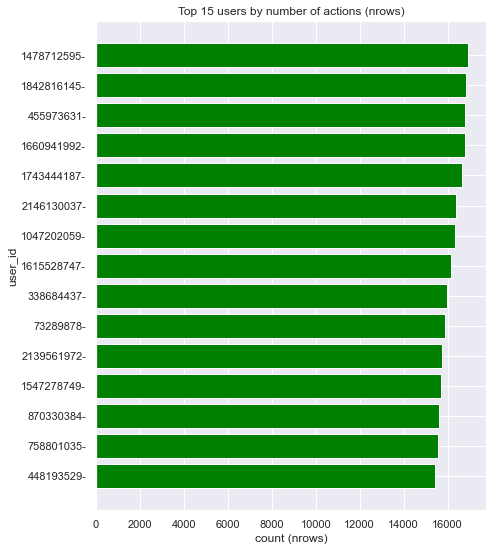

In [25]:
users_nrows = data['user_id'].value_counts().reset_index()
users_nrows.columns = ['user_id', 
                       'nrows']
#users_nrows.head()
users_nrows['user_id'] = users_nrows['user_id'].astype(str) + '-'
users_nrows = users_nrows.sort_values(['nrows'])
#users_nrows.tail(15)

users_nrows_plot = users_nrows.iloc[-16:-1, ]


fig, ax = plt.subplots(figsize = (7, 9))
plt.title('Top 15 users by number of actions (nrows)')
ax.set_xlabel('count (nrows)')
ax.set_ylabel('user_id')

plt.barh(users_nrows_plot['user_id'], 
         users_nrows_plot['nrows'],
         color = 'green')
plt.show()

Довольно бесполезное знание, кажется.

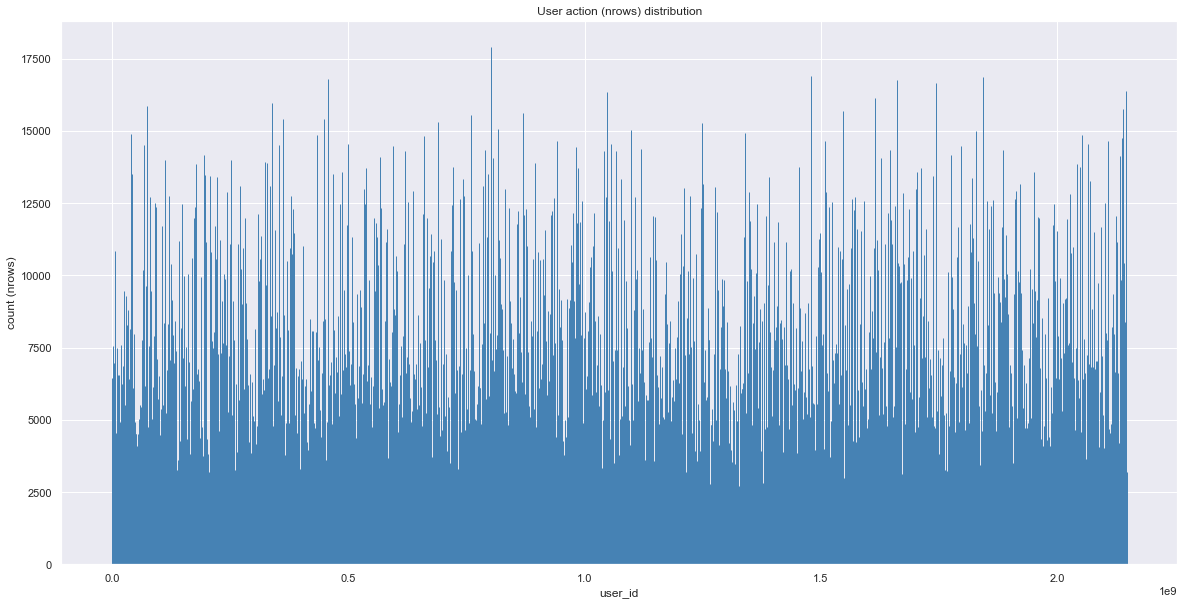

Wall time: 6min 57s


In [26]:
%%time
users_nrows = data['user_id'].value_counts().reset_index()
users_nrows.columns = ['user_id', 
                       'nrows']
users_nrows = users_nrows.sort_values(['user_id'])


#mean = users_nrows.groupby('user_id')['nrows'].mean()
#median = users_nrows.groupby('user_id')['nrows'].median()


fig, ax = plt.subplots(figsize = (20, 10))
plt.title('User action (nrows) distribution')
ax.set_xlabel('user_id')
ax.set_ylabel('count (nrows)')

#mean_patch = mpatches.Patch(color = 'orange', 
#                            label = 'Mean')
#median_patch = mpatches.Patch(color = 'red', 
#                              label  = 'Median')

plt.bar(users_nrows['user_id'], 
        users_nrows['nrows'],
        edgecolor = 'steelblue')
#plt.plot(mean, color = 'orange')
#plt.plot(median, color = 'red')   
#plt.legend(handles = [mean_patch, 
#                      median_patch],
#           fontsize = 9)

plt.show()

Довольно бесполезное знание, кажется (2).

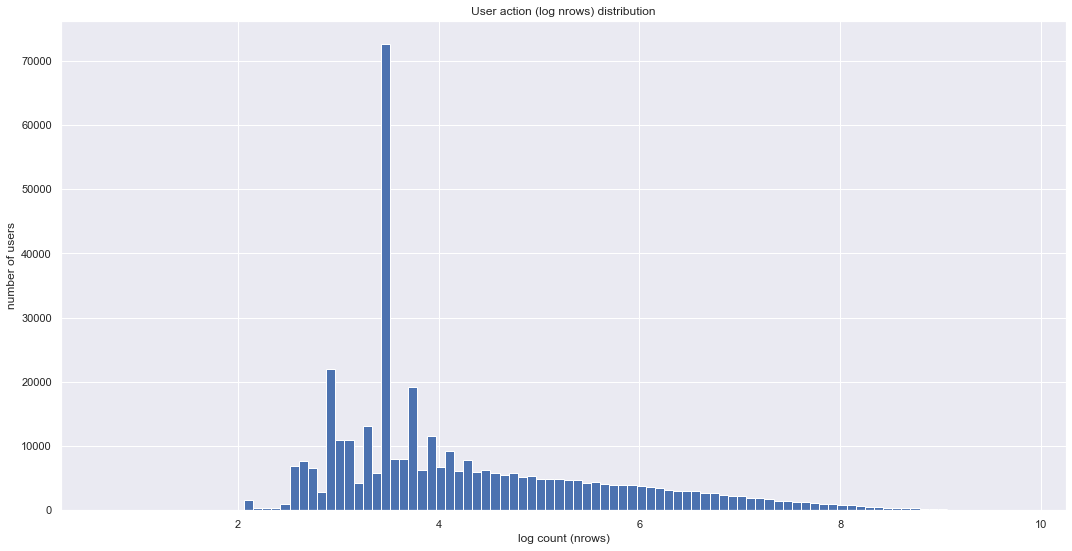

In [27]:
log_user_nrows = []

for i in range(len(users_nrows)):
    elem = np.log1p(users_nrows['nrows'][i])
    log_user_nrows.append(elem)

users_nrows['log_nrows'] = log_user_nrows
users_nrows.head(10)



fig, ax = plt.subplots(figsize=(18, 9))

ax.set_title('User action (log nrows) distribution')
ax.set_xlabel('log count (nrows)')
ax.set_ylabel('number of users')

ax.hist(users_nrows['log_nrows'], bins = 100)
plt.show()

Как минимум, оно не симметричное и явно выделяется один класс, но ничего полезного отсюда пока не видно.

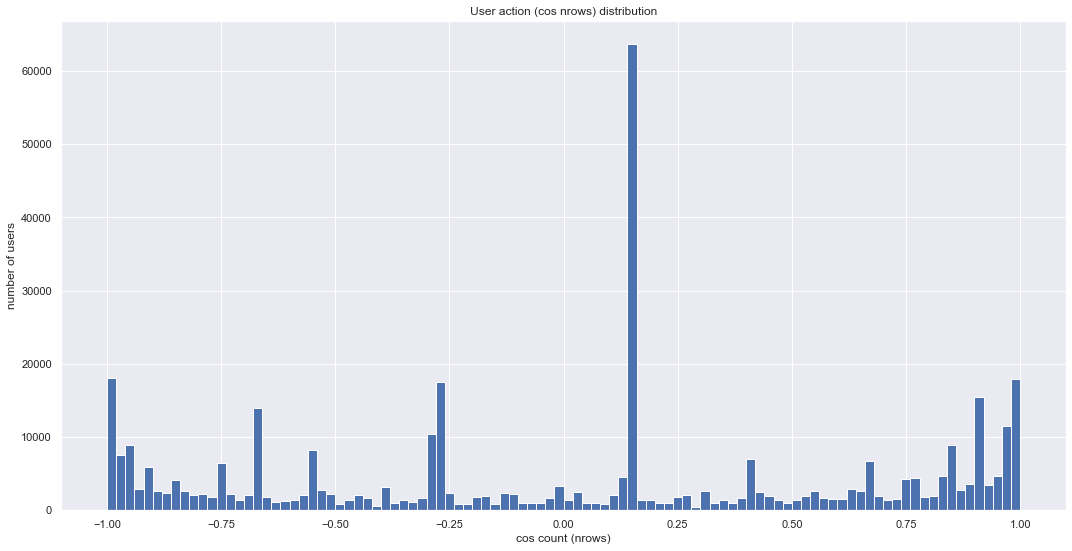

In [28]:
cos_user_nrows = []

for i in range(len(users_nrows)):
    elem = np.cos(users_nrows['nrows'][i])
    cos_user_nrows.append(elem)

users_nrows['cos_nrows'] = cos_user_nrows
users_nrows.head(10)



fig, ax = plt.subplots(figsize=(18, 9))

ax.set_title('User action (cos nrows) distribution')
ax.set_xlabel('cos count (nrows)')
ax.set_ylabel('number of users')

ax.hist(users_nrows['cos_nrows'], bins = 100)
plt.show()

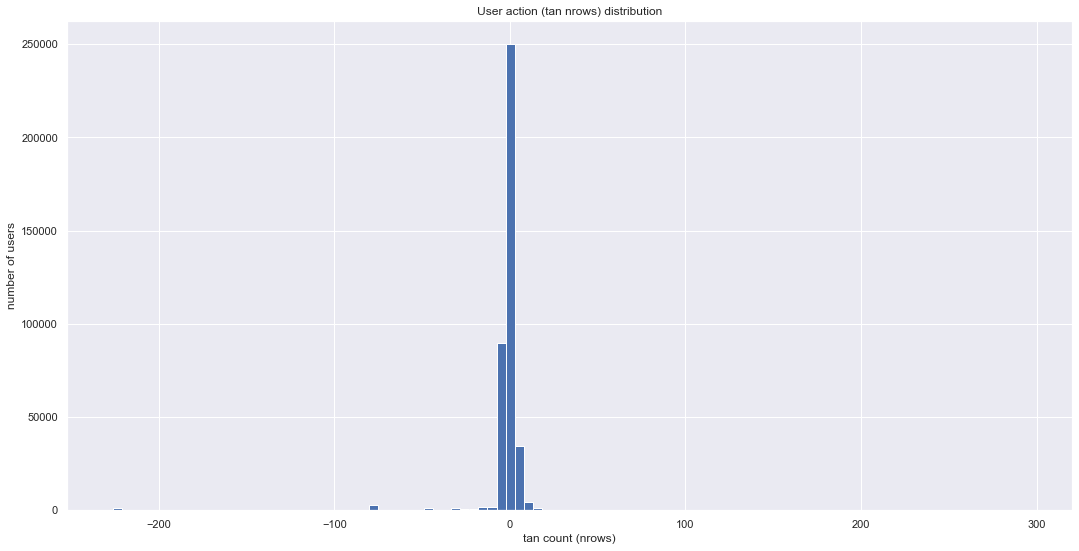

In [29]:
tan_user_nrows = []

for i in range(len(users_nrows)):
    elem = np.tan(users_nrows['nrows'][i])
    tan_user_nrows.append(elem)

users_nrows['tan_nrows'] = tan_user_nrows
users_nrows.head(10)



fig, ax = plt.subplots(figsize=(18, 9))

ax.set_title('User action (tan nrows) distribution')
ax.set_xlabel('tan count (nrows)')
ax.set_ylabel('number of users')

ax.hist(users_nrows['tan_nrows'], bins = 100)
plt.show()

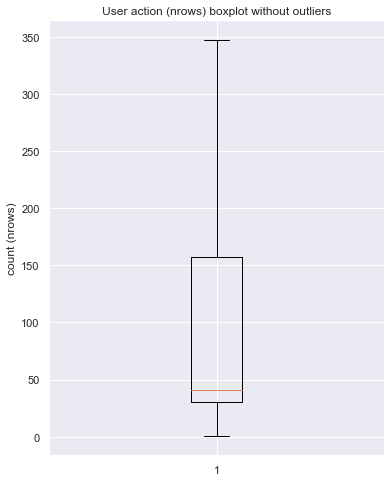

In [30]:
fig, ax = plt.subplots(figsize = (6, 8))
plt.title('User action (nrows) boxplot without outliers')
ax.set_ylabel('count (nrows)')

plt.boxplot(users_nrows['nrows'], showfliers = False) 
plt.show();

---

### Explotary data analysis. Stage 3.
<В будущем в stage 2 включить>

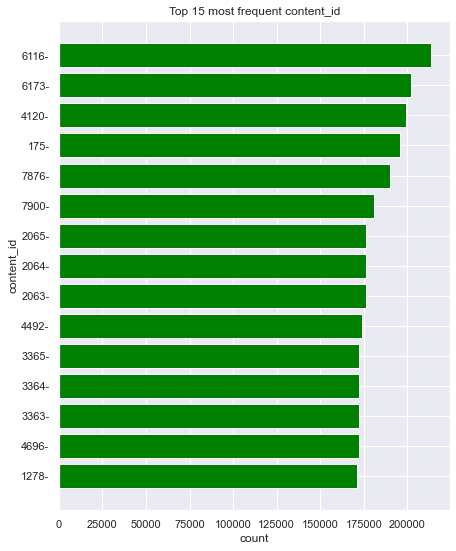

In [31]:
data_plot = data['content_id'].value_counts().reset_index()
data_plot.columns = ['content_id', 
                     'count']
data_plot['content_id'] = data_plot['content_id'].astype(str) + '-'
data_plot = data_plot.sort_values(['count']).tail(15)
#data_plot = users_nrows.data_plot[-16:-1, ]


fig, ax = plt.subplots(figsize = (7, 9))
plt.title('Top 15 most frequent content_id')
ax.set_xlabel('count')
ax.set_ylabel('content_id')

plt.barh(data_plot['content_id'], 
         data_plot['count'],
         color = 'green')
plt.show()

Довольно бесполезное знание, кажется.

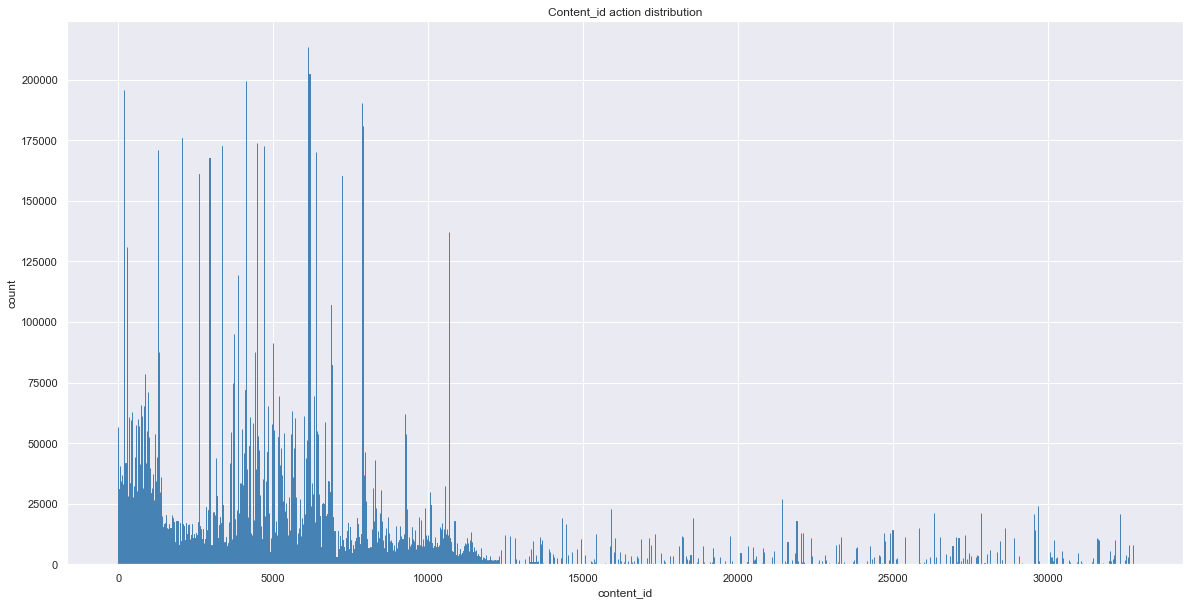

Wall time: 16 s


In [32]:
%%time
data_plot = data['content_id'].value_counts().reset_index()
data_plot.columns = ['content_id', 
                     'count']
data_plot = data_plot.sort_values('content_id')


#mean = data_plot.groupby('content_id')['count'].mean()
#median = data_plot.groupby('content_id')['count'].median()


fig, ax = plt.subplots(figsize = (20, 10))
plt.title('Content_id action distribution')
ax.set_xlabel('content_id')
ax.set_ylabel('count')

#mean_patch = mpatches.Patch(color = 'orange', 
#                            label = 'Mean')
#median_patch = mpatches.Patch(color = 'red', 
#                              label  = 'Median')

plt.bar(data_plot['content_id'], 
        data_plot['count'],
        edgecolor = 'steelblue')
#plt.plot(mean, color = 'orange')
#plt.plot(median, color = 'red')
#plt.legend(handles = [mean_patch, 
#                      median_patch])
plt.show()

<br> И довольно бесполезное знание, кажется (2).

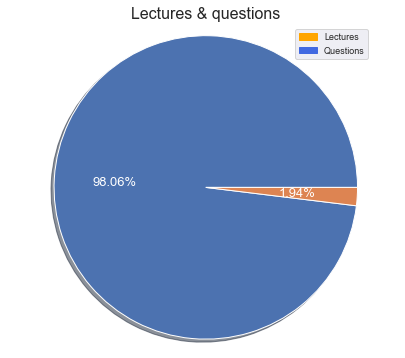

Lectures: 1959032
Questions: 99271300
---------
Wall time: 13.7 s


In [33]:
%%time
data_plot = data['content_type_id'].value_counts().reset_index()
data_plot.columns = ['content_type_id', 
                     'percent']
data_plot['percent'] /= len(data)

labels = data_plot['content_type_id']
sizes = data_plot['percent']


fig, ax = plt.subplots(figsize = (6, 6))
plt.title('Lectures & questions', fontsize = 16)

lect_patch = mpatches.Patch(color = 'orange', 
                            label = 'Lectures')
quest_patch = mpatches.Patch(color = 'royalblue', 
                             label  = 'Questions')

ax.pie(sizes, labels = labels, autopct = '%1.2f%%',
       shadow = True, startangle = 0, textprops = {'color' : "w",
                                                   'fontsize' : 13})
plt.legend(handles = [lect_patch, 
                      quest_patch],
           fontsize = 9)
ax.axis('equal') 
plt.show()

print(
      'Lectures: ', data[data['content_type_id'] == True].shape[0], '\n',
      'Questions: ', data[data['content_type_id'] == False].shape[0], '\n',
      '---------',
      sep=''
    )

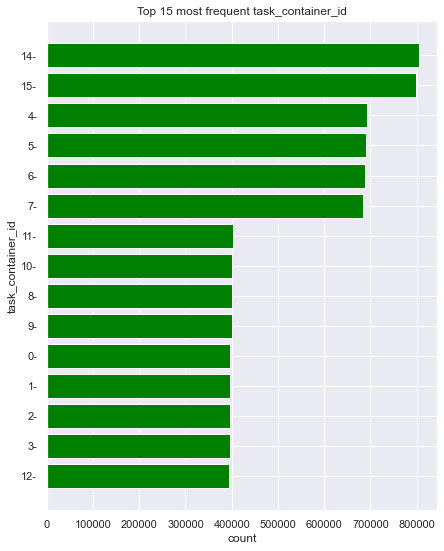

In [34]:
data_plot = data['task_container_id'].value_counts().reset_index()
data_plot.columns = ['task_container_id', 
                     'count']
data_plot['task_container_id'] = data_plot['task_container_id'].astype(str) + '-'
data_plot = data_plot.sort_values(['count']).tail(15)


fig, ax = plt.subplots(figsize = (7, 9))
plt.title('Top 15 most frequent task_container_id')
ax.set_xlabel('count')
ax.set_ylabel('task_container_id')

plt.barh(data_plot['task_container_id'], 
         data_plot['count'],
         color = 'green')
plt.show()

Довольно бесполезное знание, кажется.

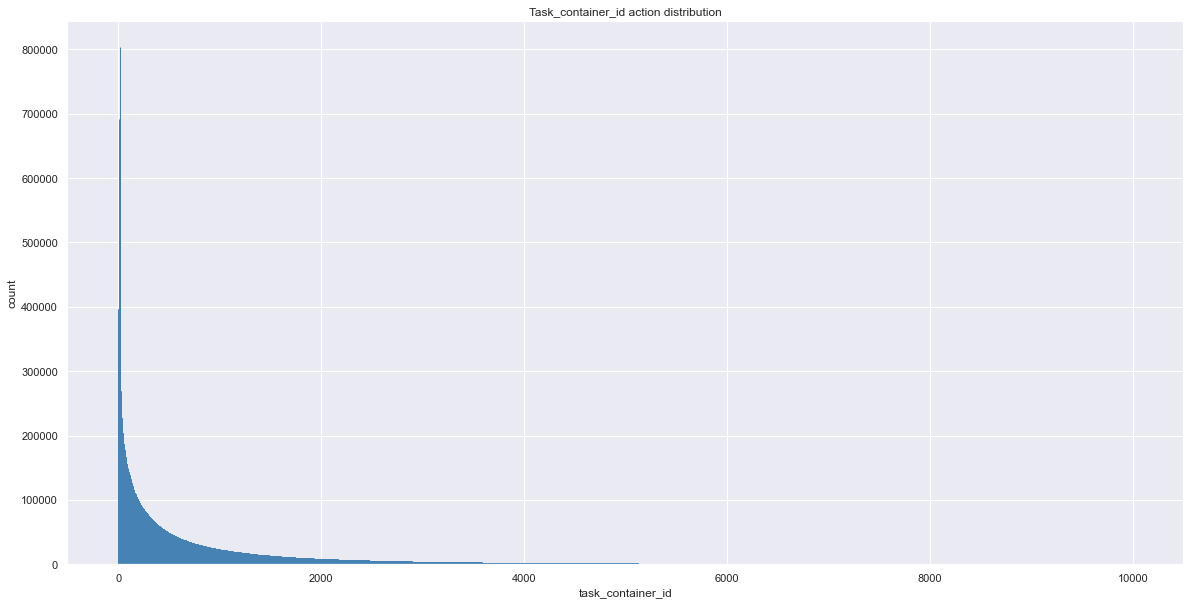

Wall time: 11.3 s


In [35]:
%%time
data_plot = data['task_container_id'].value_counts().reset_index()
data_plot.columns = ['task_container_id', 
                     'count']
data_plot = data_plot.sort_values('task_container_id')


fig, ax = plt.subplots(figsize = (20, 10))
plt.title('Task_container_id action distribution')
ax.set_xlabel('task_container_id')
ax.set_ylabel('count')

plt.bar(data_plot['task_container_id'], 
        data_plot['count'],
        edgecolor = 'steelblue')
plt.show()

Довольно бесполезное знание, кажется (2), но выглядит, как идеальная гипербола. Хм.

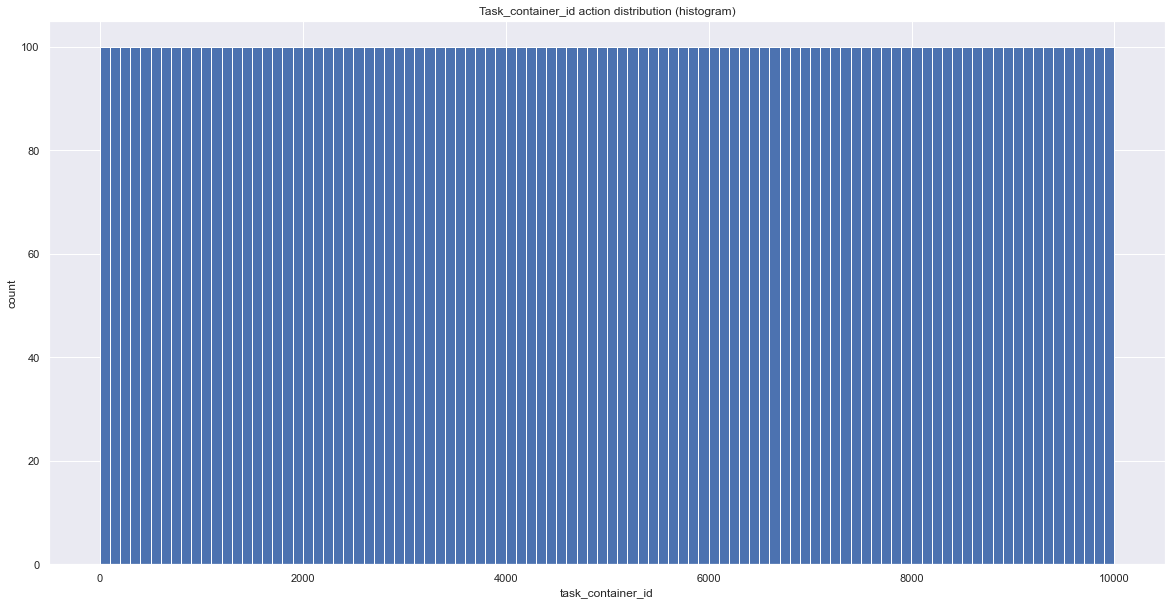

Wall time: 1.3 s


In [36]:
%%time
data_plot = data['task_container_id'].value_counts().reset_index()
data_plot.columns = ['task_container_id', 
                     'count']
data_plot = data_plot.sort_values('task_container_id')


fig, ax = plt.subplots(figsize = (20, 10))
plt.title('Task_container_id action distribution (histogram)')
ax.set_xlabel('task_container_id')
ax.set_ylabel('count')
ax.hist(data_plot['task_container_id'], bins = 100)
plt.show()

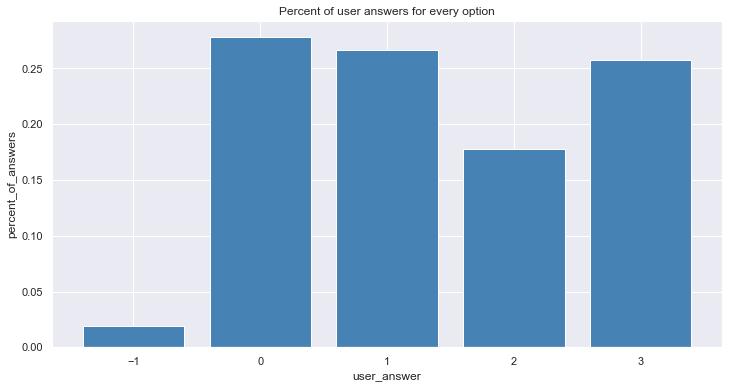

In [37]:
data_plot = data['user_answer'].value_counts().reset_index()
data_plot.columns = ['user_answer', 
                     'percent_of_answers']
data_plot['percent_of_answers'] /= len(data)
data_plot = data_plot.sort_values(['percent_of_answers'])


fig, ax = plt.subplots(figsize = (12, 6))
plt.title('Percent of user answers for every option')
ax.set_xlabel('user_answer')
ax.set_ylabel('percent_of_answers')

plt.bar(data_plot['user_answer'], 
        data_plot['percent_of_answers'],
        color = 'steelblue')
plt.show()

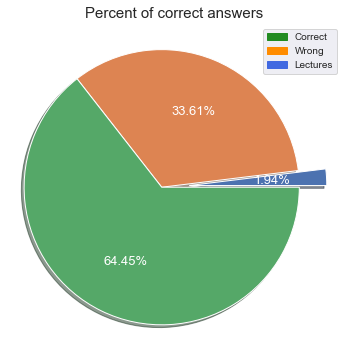

Lectures: 1959032
Correct answers: 65244627
Wrong answers: 34026673
---------
Wall time: 5.98 s


In [38]:
%%time
data_plot = data['answered_correctly'].value_counts().reset_index()
data_plot.columns = ['answered_correctly', 
                     'percent_of_answers']
data_plot['percent_of_answers'] /= len(data)
data_plot = data_plot.sort_values(['percent_of_answers'])

labels = data_plot['answered_correctly']
sizes = data_plot['percent_of_answers']


fig, ax = plt.subplots(figsize = (6, 6))
plt.title('Percent of correct answers', fontsize = 15)

corr_patch = mpatches.Patch(color = 'forestgreen', 
                             label  = 'Correct')
wr_patch = mpatches.Patch(color = 'darkorange', 
                            label = 'Wrong')
lect_patch = mpatches.Patch(color = 'royalblue', 
                             label  = 'Lectures')
explode = (0.2, 0, 0)

ax.pie(sizes, labels = labels, explode=explode,
       autopct = '%1.2f%%', shadow = True, startangle = 0, 
       textprops = {'color' : "w",
                    'fontsize' : 13})
plt.legend(handles = [corr_patch, 
                      wr_patch,
                      lect_patch],
           fontsize = 10)
ax.axis('equal') 
plt.show()

print(
      'Lectures: ', data[data['answered_correctly'] == -1].shape[0], '\n',
      'Correct answers: ', data[data['answered_correctly'] == 1].shape[0], '\n',
      'Wrong answers: ', data[data['answered_correctly'] == 0].shape[0], '\n',
      '---------',
      sep=''
    )

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [40]:
%%time
fig = make_subplots(rows = 3, cols = 2)

traces = [
          go.Bar(
                 x = [-1, 0, 1], 
                 y = [
                      len(data[(data['user_answer'] == item) & \
                               (data['answered_correctly'] == -1)]),
                      len(data[(data['user_answer'] == item) & \
                               (data['answered_correctly'] == 0)]),
                      len(data[(data['user_answer'] == item) & \
                               (data['answered_correctly'] == 1)])
                     ],
                 name = 'Option: ' + str(item),
                 text = [
                         str(round(100 * len(data[(data['user_answer'] == item) & \
                                                  (data['answered_correctly'] == -1)]) / \
                                   len(data[(data['user_answer'] == item)]), 
                                   2)) \
                         + '%',
                         str(round(100 * len(data[(data['user_answer'] == item) & \
                                                  (data['answered_correctly'] == -0)]) / \
                                   len(data[(data['user_answer'] == item)]), 
                                   2)) \
                         + '%',
                         str(round(100 * len(data[(data['user_answer'] == item) & \
                                                  (data['answered_correctly'] == 1)]) / \
                                   len(data[(data['user_answer'] == item)]), 
                                   2)) \
                         + '%',
                        ],
                 textposition = 'auto'
          ) for item in data['user_answer'].unique().tolist()
         ]

for i in range(len(traces)):
    fig.append_trace(
                     traces[i], 
                     (i // 2) + 1, 
                     (i % 2)  + 1
                    )

fig.update_layout(
                  title_text = 'Percent of correct answers for every option',
                  height = 900,
                  width = 800
                 )
fig.show()

Wall time: 35.5 s


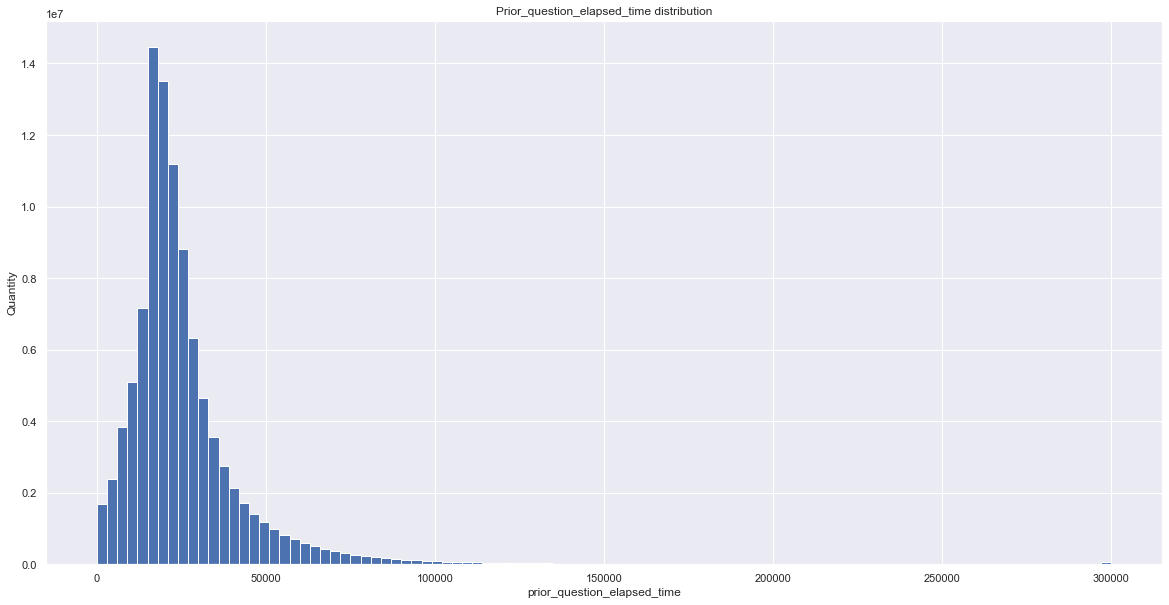

Wall time: 9min 20s


In [41]:
%%time
fig, ax = plt.subplots(figsize = (20, 10))

ax.set_title('Prior_question_elapsed_time distribution')
ax.set_xlabel('prior_question_elapsed_time')
ax.set_ylabel('Quantity')

ax.hist(data['prior_question_elapsed_time'], bins = 100)
plt.show()

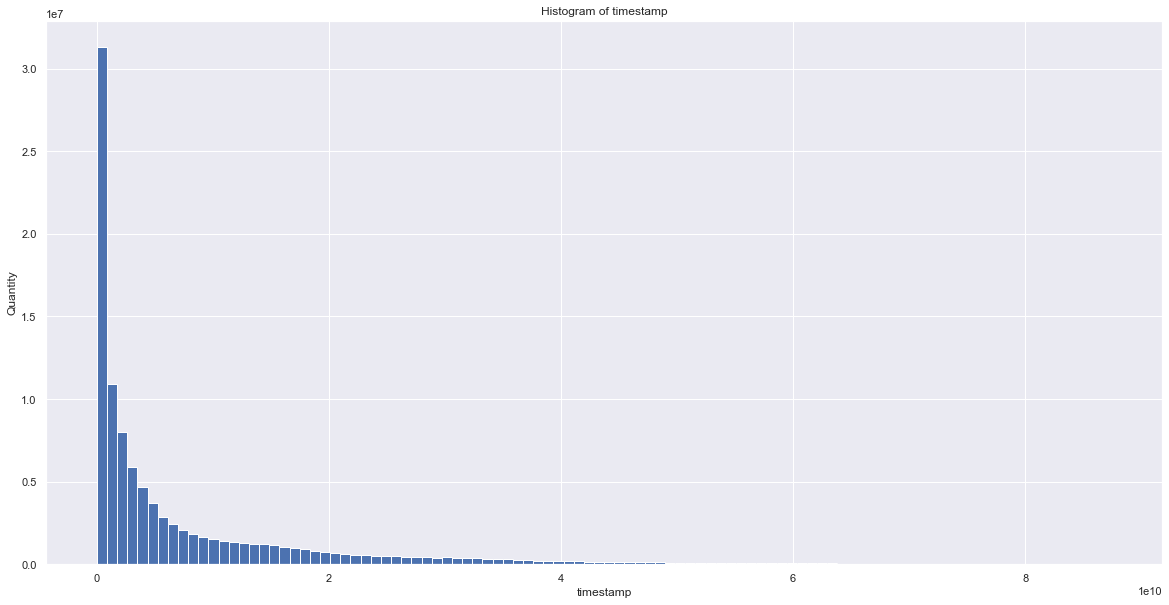

Wall time: 9min 39s


In [42]:
%%time
fig, ax = plt.subplots(figsize = (20, 10))

ax.set_title('Histogram of timestamp')
ax.set_xlabel('timestamp')
ax.set_ylabel('Quantity')

ax.hist(data['timestamp'], bins = 100)
plt.show()

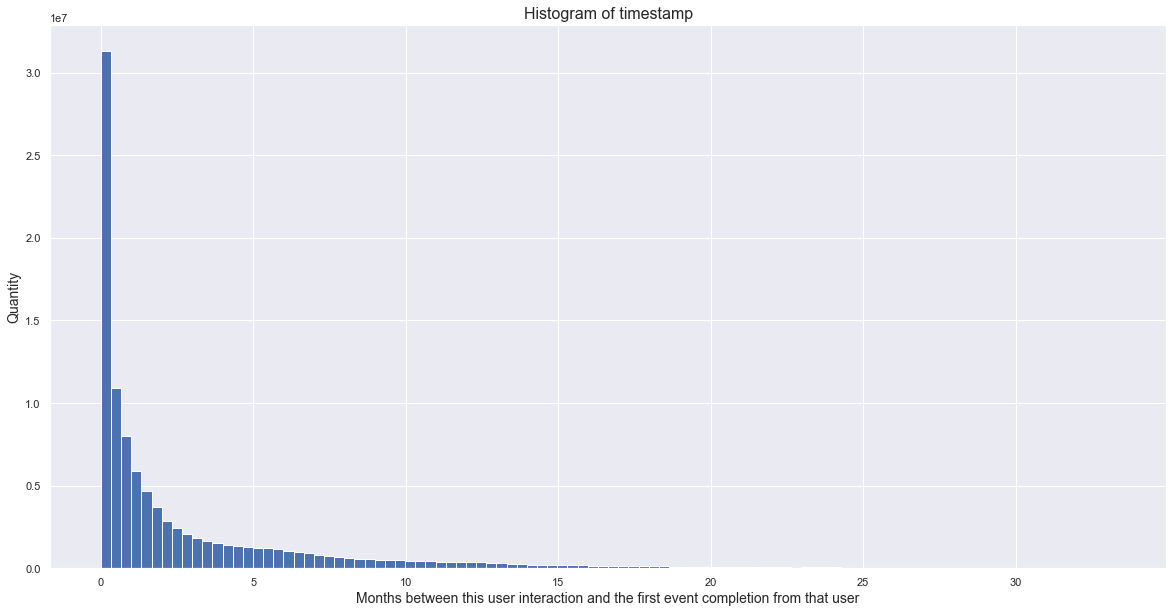

Wall time: 10min 4s


In [43]:
%%time
data_plot = data['timestamp'] / \
                               (31536000000 / 12)      ## 1 year = 31536000000 ms

fig, ax = plt.subplots(figsize = (20, 10))

ax.set_title('Histogram of timestamp', fontsize = 16)
ax.set_xlabel('Months between this user interaction and the first event completion from that user', fontsize = 14)
ax.set_ylabel('Quantity', fontsize = 14)

ax.hist(data_plot, bins = 100)
plt.show()

In [44]:
def correct(field):
    
    correct = data[data['answered_correctly'] != -1]. \
                                                      groupby([field, 'answered_correctly'], 
                                                              as_index = False). \
                                                      size()
    correct = correct.pivot(index = field, 
                            columns = 'answered_correctly', 
                            values='size')
    correct['percent_correct'] = round(correct.iloc[:, 1] / \
                                                        (correct.iloc[:, 0] + \
                                                         correct.iloc[:, 1]),
                                       2)
    correct = correct.sort_values(by = "percent_correct", 
                                  ascending = False)
    correct = correct.iloc[:, 2]
    
    return(correct)

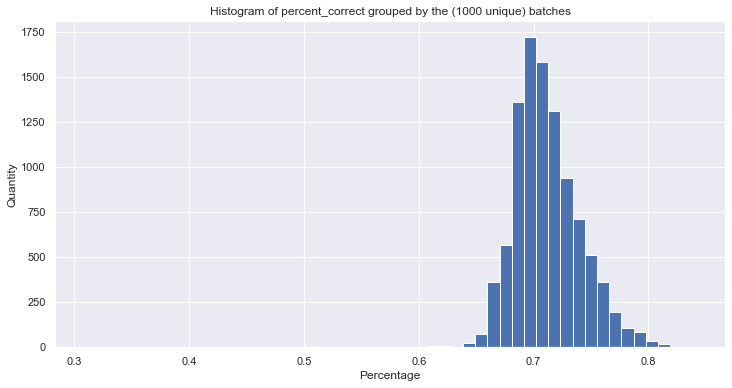

In [45]:
data_plot = correct('task_container_id')

fig, ax = plt.subplots(figsize = (12, 6))
plt.title("Histogram of percent_correct grouped by the (1000 unique) batches")
plt.xticks(rotation = 0)
ax.set_xlabel('Percentage')
ax.set_ylabel('Quantity')

ax.hist(data_plot, bins = 50)
plt.show()

As some users have answered huge amounts of questions, I have taken out the outliers (user_ids with 1000+ questions answered):

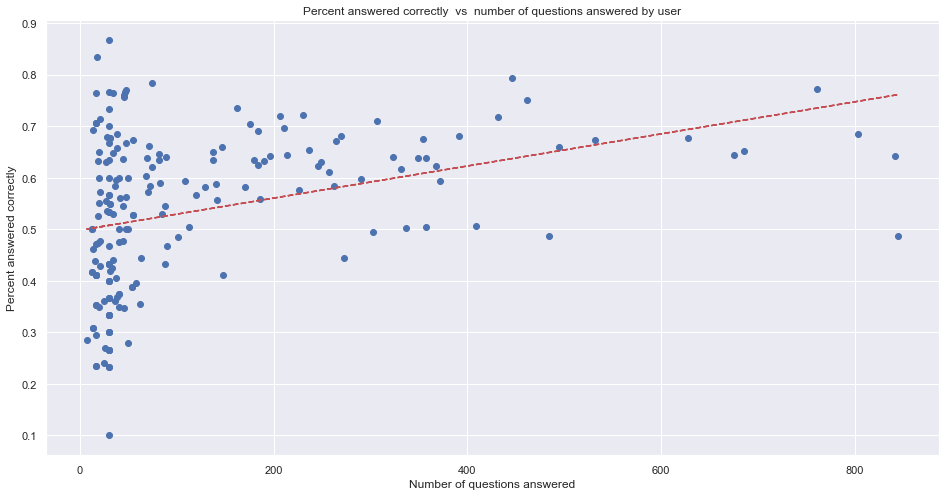

In [46]:
user_percent = data[data['answered_correctly'] != -1]. \
                                                      groupby('user_id')['answered_correctly']. \
                                                      agg(mean = 'mean', 
                                                          answers = 'count')
user_percent = user_percent.query('answers <= 1000'). \
                                                     sample(n = 200, 
                                                            random_state=1)

x = user_percent['answers']
y = user_percent['mean']


fig, ax = plt.subplots(figsize = (16, 8))
plt.title("Percent answered correctly  vs  number of questions answered by user")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.scatter(x, y, marker='o')
plt.plot(x, p(x), "r--")
plt.show()

As you can see, the trend is upward but there is also a lot of variation among users that have answered few questions.

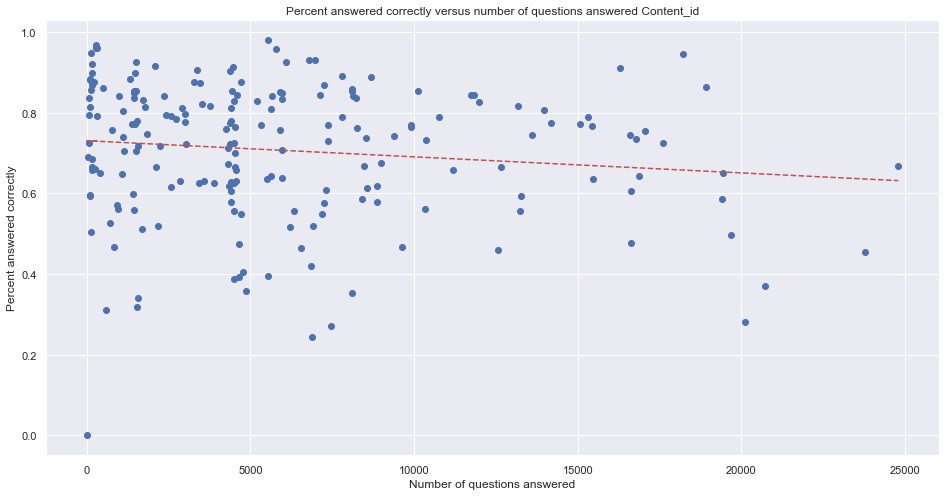

In [47]:
content_percent = data[data['answered_correctly'] != -1]. \
                                                         groupby('content_id')['answered_correctly']. \
                                                         agg(mean = 'mean', 
                                                             answers = 'count')
content_percent = content_percent.query('answers <= 25000'). \
                                                            sample(n = 200, 
                                                                   random_state = 1)

x = content_percent['answers']
y = content_percent['mean']


fig, ax = plt.subplots(figsize = (16, 8))
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.scatter(x, y, marker='o')
plt.plot(x, p(x), "r--")
plt.show()

Does it help if the 'prior_question_had_explanation'? Yes, as you can see the percent answered correctly is about 17% higher when there was an explanation. Although it is probably better to treat not having an explanation as a disadvantage as there was an explanation before the vast majority of questions.

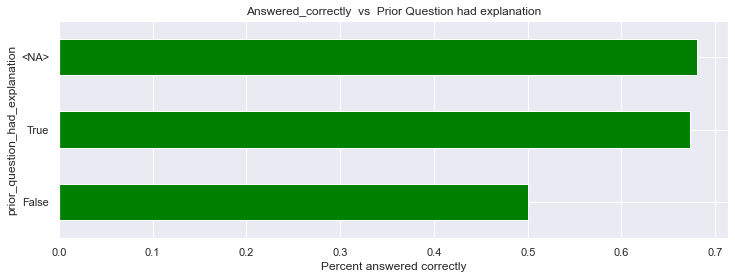

In [48]:
data_plot = data[data['answered_correctly'] != -1]. \
                                                   groupby(['prior_question_had_explanation'], 
                                                           dropna = False). \
                                                   agg({'answered_correctly': ['mean', 
                                                                               'count']})
data_plot = data_plot.iloc[:,0]


fig = plt.figure(figsize = (12, 4))
plt.title("Answered_correctly  vs  Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)

data_plot.plot.barh(color = 'green')
plt.show()

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

At first glance, this does not seem very interesting regarding our target. For both wrong and correct answers, the mean is about 25 seconds.

---

### Loading the rest of the data.

In [50]:
%%time

questions = pd.read_csv(r"\Data\questions.csv")
lectures = pd.read_csv(r"\Data\lectures.csv")
example_test = pd.read_csv(r"\Data\example_test.csv")
example_sample_submission = pd.read_csv(r"\Data\example_sample_submission.csv")

Wall time: 56.9 ms


---

### Exploring Questions. Stage 1.

**questions.csv**:

* QUESTION_ID: foreign key for the train/test content_id column, when the content type is question (0).

* BUNDLE_ID: code for which questions are served together.

* CORRECT_ANSWER: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

* PART: the relevant section of the TOEIC test.

* TAGS: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [51]:
bold('**Shape of our questions data:**')
display(questions.shape)

**Shape of our questions data:**

(13523, 5)

In [52]:
questions.head(10)

question_id  bundle_id  correct_answer  part            tags
0            0          0               0     1   51 131 162 38
1            1          1               1     1       131 36 81
2            2          2               0     1  131 101 162 92
3            3          3               0     1  131 149 162 29
4            4          4               3     1    131 5 162 38
5            5          5               2     1  131 149 162 81
6            6          6               2     1    10 94 162 92
7            7          7               0     1   61 110 162 29
8            8          8               3     1   131 13 162 92
9            9          9               3     1       10 164 81

In [53]:
bold('**Questions information:**')
display(questions.info())

**Questions information:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


None

- Удалить question_id?
- tags привести явно к str
- поделать что-то с tags - посмотреть на корреляцию с part, явно на какие-то группы (или почти) разбивается (погуглить работу с тэгами)

In [54]:
print('question_id max:', np.max(questions['question_id']))
print('bundle_id max:', np.max(questions['bundle_id']))
questions.iloc[1400:1407, ]

question_id max: 13522
bundle_id max: 13522


question_id  bundle_id  correct_answer  part        tags
1400         1400       1400               0     3   74 92 102
1401         1401       1400               0     3  136 92 102
1402         1402       1400               1     3   82 92 102
1403         1403       1403               1     3   106 38 29
1404         1404       1403               0     3   136 38 29
1405         1405       1403               3     3    82 38 29
1406         1406       1406               2     3  106 38 102

По всей видимости, bundle_id $\subset$ question_id.
<br>Что, собственно, правда, ибо вытекает из определения bundle_id и question_id можно удалить.

In [55]:
bold("**Percentage of missing values for every column:**")
display(
        questions.isnull().sum() / len(questions) * 100
)

**Percentage of missing values for every column:**

question_id       0.000000
bundle_id         0.000000
correct_answer    0.000000
part              0.000000
tags              0.007395
dtype: float64

In [56]:
questions[questions['tags'].isnull()]

question_id  bundle_id  correct_answer  part tags
10033        10033      10033               2     6  NaN

Also.....when looking at train, we see that this question was just asked once.

In [57]:
data.query('content_id == "10033" and answered_correctly != -1')

timestamp     user_id  content_id  content_type_id  \
62750278  1286282597  1333688829       10033            False   

          task_container_id  user_answer  answered_correctly  \
62750278               1127            2                   1   

          prior_question_elapsed_time  prior_question_had_explanation  
62750278                      35000.0                            True

In [58]:
#questions = questions.drop('question_id', 1)
#questions.head()

In [59]:
#questions['tags'] = questions['tags'].astype(str)
#questions.info()

In [60]:
bold('**Number of unique bundle_ids:**')
display(
        len(
            np.unique(questions['bundle_id'])
        )
)

**Number of unique bundle_ids:**

9765

In [61]:
bold('**Number of unique parts:**')
display(
        len(
            np.unique(questions['part'])
        )
)

**Number of unique parts:**

7

In [62]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() \
                for x in questions[questions['tags'] != "nan"] \
                                                                ['tags']. \
                                                                values]
tags = [item \
            for elem in tags \
                for item in elem]
tags = set(tags)
tags = list(tags)

bold('**Number of unique tags:**')
display(
        len(tags)
)

**Number of unique tags:**

188

In [63]:
orig_questions = questions
orig_questions.head()

question_id  bundle_id  correct_answer  part            tags
0            0          0               0     1   51 131 162 38
1            1          1               1     1       131 36 81
2            2          2               0     1  131 101 162 92
3            3          3               0     1  131 149 162 29
4            4          4               3     1    131 5 162 38

In [64]:
questions['tag'] = questions['tags']. \
                                     str. \
                                     split(' ')
questions = questions.explode('tag')
questions = pd.merge(
                     questions, 
                     questions. \
                               groupby('question_id')['tag']. \
                               count(). \
                               reset_index(), 
                     on = 'question_id'
                    )

questions.head()

question_id  bundle_id  correct_answer  part           tags tag_x  tag_y
0            0          0               0     1  51 131 162 38    51      4
1            0          0               0     1  51 131 162 38   131      4
2            0          0               0     1  51 131 162 38   162      4
3            0          0               0     1  51 131 162 38    38      4
4            1          1               1     1      131 36 81   131      3

In [65]:
questions_split = questions.copy()
questions_split.columns = [
                           'question_id', 
                           'bundle_id', 
                           'correct_answer', 
                           'part', 
                           'tags',
                           'splitted_tag', 
                           'number_of_tags'
                          ]
questions_split = questions_split.drop_duplicates()

questions_split.head()

question_id  bundle_id  correct_answer  part           tags splitted_tag  \
0            0          0               0     1  51 131 162 38           51   
1            0          0               0     1  51 131 162 38          131   
2            0          0               0     1  51 131 162 38          162   
3            0          0               0     1  51 131 162 38           38   
4            1          1               1     1      131 36 81          131   

   number_of_tags  
0               4  
1               4  
2               4  
3               4  
4               3

In [66]:
questions = questions.drop(['tag_x'], axis=1)
questions.columns = [
                     'question_id', 
                     'bundle_id', 
                     'correct_answer', 
                     'part', 
                     'tags', 
                     'number_of_tags'
                    ]
questions = questions.drop_duplicates()

questions.head()

question_id  bundle_id  correct_answer  part            tags  \
0             0          0               0     1   51 131 162 38   
4             1          1               1     1       131 36 81   
7             2          2               0     1  131 101 162 92   
11            3          3               0     1  131 149 162 29   
15            4          4               3     1    131 5 162 38   

    number_of_tags  
0                4  
4                3  
7                4  
11               4  
15               4

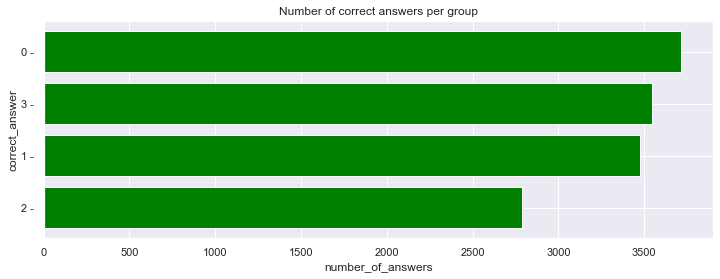

In [67]:
data_plot = questions['correct_answer']. \
                                        value_counts(). \
                                        reset_index()
data_plot.columns = ['correct_answer', 
                     'number_of_answers']

data_plot['correct_answer'] = data_plot['correct_answer']. \
                                                          astype(str) + \
                                                          ' -'
data_plot = data_plot.sort_values(['number_of_answers'])


fig = plt.figure(figsize = (12, 4))
plt.title("Number of correct answers per group")
plt.xlabel("number_of_answers")
plt.ylabel("correct_answer")

plt.barh(data_plot['correct_answer'], 
         data_plot['number_of_answers'],
         color = 'green')
plt.show()

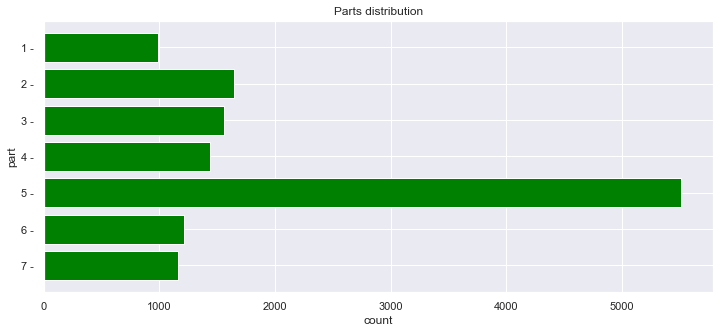

In [68]:
data_plot = questions['part']. \
                              value_counts(). \
                              reset_index()
data_plot.columns = ['part', 
                     'count']

data_plot['part'] = data_plot['part']. \
                                      astype(str) + \
                                      ' -'
data_plot = data_plot.sort_values(['part'],
                                  ascending = False)


fig = plt.figure(figsize = (12, 5))
plt.title("Parts distribution")
plt.xlabel("count")
plt.ylabel("part")

plt.barh(data_plot['part'], 
         data_plot['count'],
         color = 'green')
plt.show()

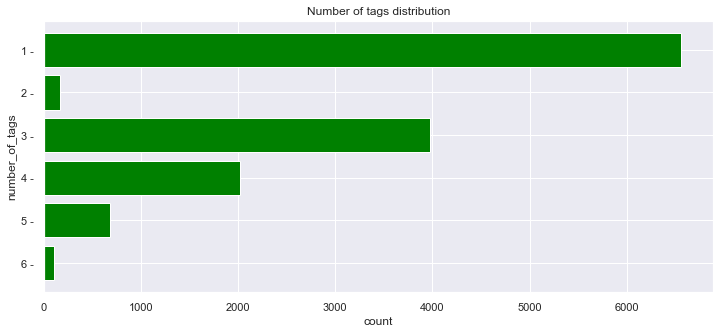

In [69]:
data_plot = questions['number_of_tags']. \
                                        value_counts(). \
                                        reset_index()
data_plot.columns = ['number_of_tags', 
                     'count']

data_plot['number_of_tags'] = data_plot['number_of_tags']. \
                                                          astype(str) + \
                                                          ' -'
data_plot = data_plot.sort_values(['number_of_tags'],
                                  ascending = False)


fig = plt.figure(figsize = (12, 5))
plt.title("Number of tags distribution")
plt.xlabel("count")
plt.ylabel("number_of_tags")

plt.barh(data_plot['number_of_tags'], 
         data_plot['count'],
         color = 'green')
plt.show()

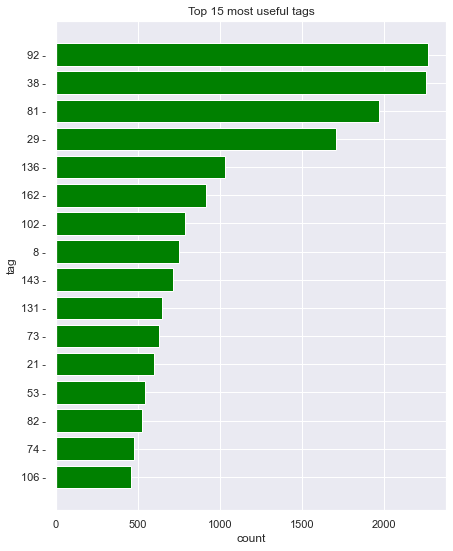

In [70]:
data_plot = questions['tags']. \
                              str. \
                              split(' '). \
                              explode('tags'). \
                              reset_index()
data_plot = data_plot['tags']. \
                              value_counts(). \
                              reset_index()
data_plot.columns = ['tag', 'count']

data_plot['tag'] = data_plot['tag']. \
                                    astype(str) + \
                                    ' -'
data_plot = data_plot.iloc[:16, ].sort_values('count')


fig, ax = plt.subplots(figsize = (7, 9))
plt.title('Top 15 most useful tags')
ax.set_xlabel('count')
ax.set_ylabel('tag')

plt.barh(data_plot['tag'], 
         data_plot['count'],
         color = 'green')
plt.show()

In [71]:
tags_list = [x.split() \
                     for x in questions.tags.values]
questions['tags_list'] = tags_list
questions.head()

question_id  bundle_id  correct_answer  part            tags  \
0             0          0               0     1   51 131 162 38   
4             1          1               1     1       131 36 81   
7             2          2               0     1  131 101 162 92   
11            3          3               0     1  131 149 162 29   
15            4          4               3     1    131 5 162 38   

    number_of_tags            tags_list  
0                4   [51, 131, 162, 38]  
4                3        [131, 36, 81]  
7                4  [131, 101, 162, 92]  
11               4  [131, 149, 162, 29]  
15               4    [131, 5, 162, 38]

In [72]:
correct = data[data['answered_correctly'] != -1]. \
                                                 groupby(['content_id', 
                                                          'answered_correctly'], 
                                                          as_index = False). \
                                                 size()
correct = correct.pivot(index = 'content_id', 
                        columns = 'answered_correctly', 
                        values = 'size')
correct.columns = ['Num_of_Wrong', 'Num_of_Right']
correct = correct.fillna(0)
correct[['Num_of_Wrong', 'Num_of_Right']] = correct[['Num_of_Wrong', 
                                                     'Num_of_Right']]. \
                                                                      astype(int)

questions = questions.merge(correct, 
                            left_on = 'question_id', 
                            right_on = 'content_id',
                            how = "left")

bold('**Answers were wrong and right per question_id (per content_id in train data):**')
questions.head(6)

**Answers were wrong and right per question_id (per content_id in train data):**

question_id  bundle_id  correct_answer  part            tags  \
0            0          0               0     1   51 131 162 38   
1            1          1               1     1       131 36 81   
2            2          2               0     1  131 101 162 92   
3            3          3               0     1  131 149 162 29   
4            4          4               3     1    131 5 162 38   
5            5          5               2     1  131 149 162 81   

   number_of_tags            tags_list  Num_of_Wrong  Num_of_Right  
0               4   [51, 131, 162, 38]           637          6266  
1               3        [131, 36, 81]           809          6589  
2               4  [131, 101, 162, 92]         20015         24890  
3               4  [131, 149, 162, 29]          5067         17906  
4               4    [131, 5, 162, 38]         12275         19461  
5               4  [131, 149, 162, 81]          1344          8383

Now, I can add up all Wrong and Right answers for all questions that are labeled with a particular tag and calculate the percent correct for each tag. Please note that there is "double counting" of questions; for instance if a question has 5 tags, its answers are aggregated in the totals of each of the 5 tags.

In [73]:
%%time
tags_df = pd.DataFrame()

for x in range(len(tags)):
    df = questions[
                   questions['tags']. \
                                     apply(lambda l: tags[x] in l)
                  ]
    df_tmp = df.agg({'Num_of_Wrong': ['sum'], 
                     'Num_of_Right': ['sum']})
    df_tmp['Total_questions'] = df_tmp['Num_of_Wrong'] + df_tmp['Num_of_Right']
    df_tmp['Num_of_question_ids_with_tag'] = len(df)
    df_tmp['tag'] = tags[x]
    df_tmp = df_tmp.set_index('tag')
    tags_df = tags_df.append(df_tmp)

    
tags_df[['Num_of_Wrong', 
         'Num_of_Right', 
         'Total_questions']] = tags_df[['Num_of_Wrong', 
                                        'Num_of_Right', 
                                        'Total_questions']]. \
                                                             astype(int)
tags_df['Percent_correct'] = tags_df['Num_of_Right'] / \
                                                       tags_df['Total_questions']
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head(6)

Wall time: 1.01 s


Num_of_Wrong  Num_of_Right  Total_questions  \
tag                                                
151        272267        264913           537180   
24         258085        253221           511306   
23         540798        532011          1072809   
167        170386        170681           341067   
108        234504        238296           472800   
67         983588       1138475          2122063   

     Num_of_question_ids_with_tag  Percent_correct  
tag                                                 
151                            16         0.493155  
24                             29         0.495244  
23                             40         0.495905  
167                            11         0.500432  
108                            20         0.504010  
67                            338         0.536494

Давайте посмотрим на разницу:

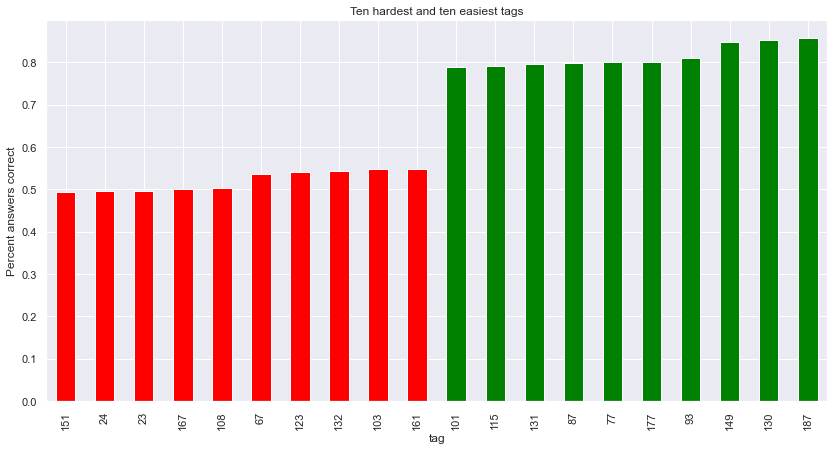

In [74]:
select_rows = list(range(0, 10)) + \
              list(
                   range(178, 
                         len(tags_df))
                   )
tags_select = tags_df.iloc[select_rows, 4]

x = tags_select.index
y = tags_select.values


fig = plt.figure(figsize = (14, 7))
plt.title("Ten hardest and ten easiest tags")
plt.xlabel("Tag")
plt.ylabel("Percent answers correct")
plt.xticks(rotation=90)

clrs = ['red' if y < 0.6 \
              else 'green' \
                  for y in tags_select.values]
tags_select.plot.bar(x, 
                     y, 
                     color = clrs)
plt.show()

Разница заметка невооруженным глазом.

However, we should also realize that the tag with the worst percent_correct only has about 250,000 answers. This a low number compared to the tags with most answers.

In [75]:
from matplotlib.ticker import FuncFormatter

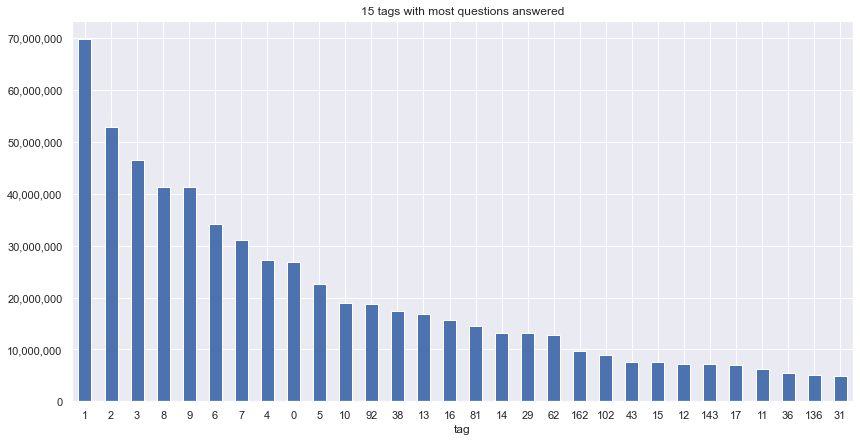

In [76]:
tags_select = tags_df.sort_values(by = "Total_questions", 
                                  ascending = False). \
                      iloc[:30, :]
tags_select = tags_select["Total_questions"]


fig = plt.figure(figsize = (14, 7))
plt.title("15 tags with most questions answered")
ax.set_xlabel('tag')
ax.set_ylabel('count')

ax = tags_select.plot.bar()
plt.xticks(rotation = 0)
plt.ticklabel_format(style = 'plain', 
                     axis = 'y')
ax.get_yaxis(). \
   set_major_formatter(
                       FuncFormatter(
                                     lambda x, p: format(int(x), 
                                                         ',')
                                    )
                      ) #add thousands separator
plt.show()

What are the so-called "Parts"? When following the link provided in the data description we find out that this relates to a test.

> The TOEIC L&R uses an optically-scanned answer sheet. There are 200 questions to answer in two hours in Listening (approximately 45 minutes, 100 questions) and Reading (75 minutes, 100 questions).

The listening section consists of Part 1-4 (Listening Section (approx. 45 minutes, 100 questions)).

The reading section consists of Part 5-7 (Reading Section (75 minutes, 100 questions)).

Below, I am displaying the count and percent correct by part. As you can see, Part 5 has a lot more question_id's and is also the most difficult.

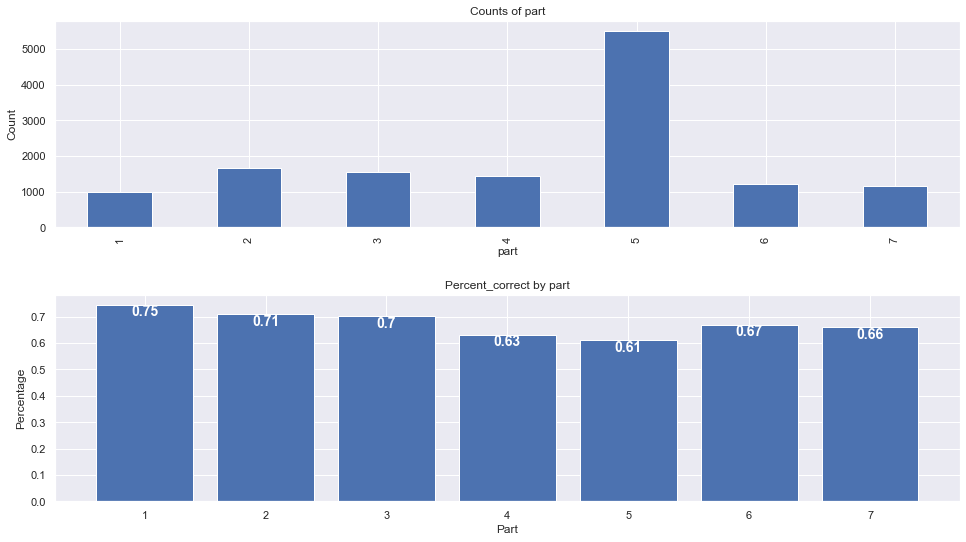

In [77]:
fig = plt.figure(figsize = (14, 8))

ax1 = fig.add_subplot(211)
plt.title("Counts of part")
plt.xlabel("Part")
plt.ylabel("Count") 
plt.xticks(rotation = 0)
ax1 = questions.groupby("part"). \
                count() \
                ['question_id']. \
                plot. \
                bar()

part = questions.groupby('part'). \
                 agg({'Num_of_Wrong': ['sum'], 
                      'Num_of_Right': ['sum']})
part['Percent_correct'] = part['Num_of_Right'] / \
                                              (part['Num_of_Right'] + \
                                               part['Num_of_Wrong'])
part = part.iloc[:, 2]


ax2 = fig.add_subplot(212)
plt.title("Percent_correct by part")
plt.xlabel("Part") 
plt.ylabel("Percentage") 
plt.xticks(rotation = 0)
plt.tight_layout(pad = 2)

plt.bar(part.index, 
        part.values)
for i, v in zip(part.index, part.values):
    plt.text(i, 
             v, 
             round(v, 2), 
             color = 'white', 
             fontweight = 'bold', 
             fontsize = 14, 
             va = 'top', 
             ha = 'center')

plt.show()

---

### Exploring Lectures. Stage 1.

**lectures.csv**:

* LECTURE_ID: foreign key for the train/test content_id column, when the content type is lecture (1).

* PART: top level category code for the lecture.

* TAG: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

* TYPE_OF: brief description of the core purpose of the lecture

In [78]:
bold('**Shape of our lectures data:**')
display(lectures.shape)

**Shape of our lectures data:**

(418, 4)

In [79]:
lectures.head(10)

lecture_id  tag  part           type_of
0          89  159     5           concept
1         100   70     1           concept
2         185   45     6           concept
3         192   79     5  solving question
4         317  156     5  solving question
5         335  114     2           concept
6         484  179     5           concept
7         641  134     6  solving question
8         761   93     1           concept
9         814   80     5  solving question

In [80]:
bold('**Lectures information:**')
display(lectures.info())

**Lectures information:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


None

- type_of привести явно к str
- поделать что-то с tags - посмотреть на корреляцию с part, явно на какие-то группы (или почти) разбивается (погуглить работу с тэгами)

In [81]:
bold("**Percentage of missing values for every column:**")
display(
        lectures.isnull().sum() / len(lectures) * 100
)

**Percentage of missing values for every column:**

lecture_id    0.0
tag           0.0
part          0.0
type_of       0.0
dtype: float64

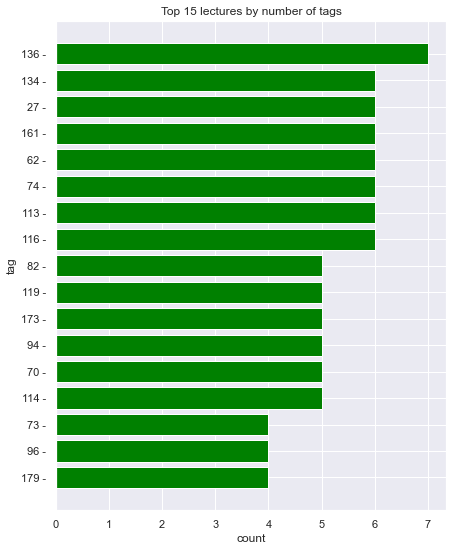

In [82]:
data_plot = lectures['tag']. \
                            value_counts(). \
                            reset_index()
data_plot.columns = ['tag', 
                     'count']

data_plot['tag'] = data_plot['tag']. \
                                    astype(str) + \
                                    ' -'
data_plot = data_plot.sort_values(['count'],
                                  ascending = False). \
                      iloc[16::-1, ]


fig, ax = plt.subplots(figsize = (7, 9))
plt.title('Top 15 lectures by number of tags')
ax.set_xlabel('count')
ax.set_ylabel('tag')

plt.barh(data_plot['tag'], 
         data_plot['count'],
         color = 'green')
plt.show()

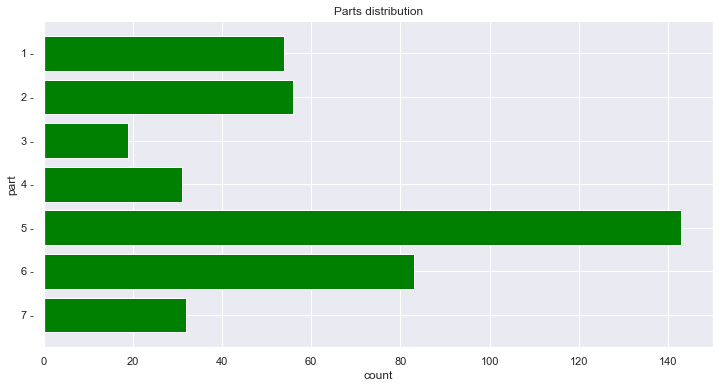

In [83]:
data_plot = lectures['part']. \
                             value_counts(). \
                             reset_index()
data_plot.columns = ['part',
                     'count']

data_plot['part'] = data_plot['part']. \
                                      astype(str) + \
                                      ' -'
data_plot = data_plot.sort_values(['part'],
                                 ascending = False)


fig, ax = plt.subplots(figsize = (12, 6))
plt.title('Parts distribution')
ax.set_xlabel('count')
ax.set_ylabel('part')

plt.barh(data_plot['part'], 
        data_plot['count'],
        color = 'green')
plt.show()

Проверить с распределением для questions.

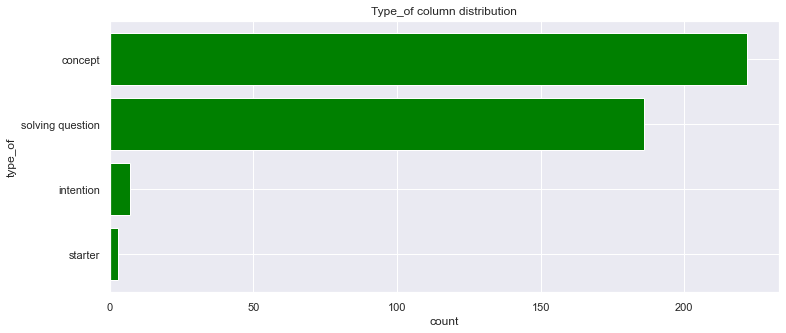

In [84]:
data_plot = lectures['type_of']. \
                                value_counts(). \
                                reset_index()
data_plot.columns = ['type_of',
                     'count']

data_plot = data_plot.sort_values(['count'])


fig, ax = plt.subplots(figsize = (12, 5))
plt.title('Type_of column distribution')
ax.set_xlabel('count')
ax.set_ylabel('type_of')

plt.barh(data_plot['type_of'], 
        data_plot['count'],
        color = 'green')
plt.show()

Since there are not that many lectures, I want to check if it helps if a user watches lectures at all. As you can see, it helps indeed!

False    244050
True     149606
Name: Watches_lecture, dtype: int64

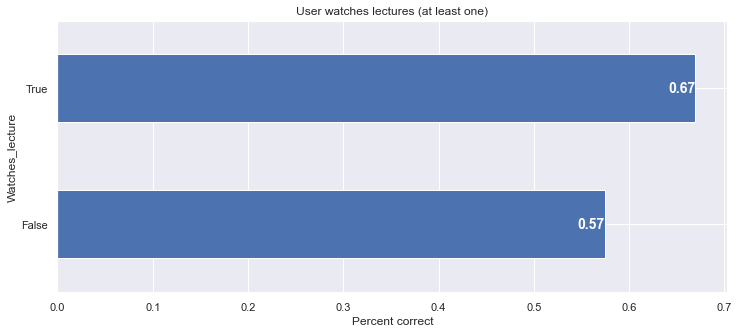

In [85]:
user_lect = data.groupby(['user_id', 
                          'answered_correctly']). \
                 size(). \
                 unstack()
user_lect.columns = ['Lecture', 
                     'Num_of_Wrong', 
                     'Num_of_Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(
                                        user_lect['Lecture'] > 0, 
                                        True, 
                                        False
                                       )

watches_l = user_lect.groupby("Watches_lecture"). \
                      agg({'Num_of_Wrong': ['sum'], 
                           'Num_of_Right': ['sum']})
display(
        user_lect['Watches_lecture'].value_counts()
)
watches_l['Percent_correct'] = watches_l['Num_of_Right'] / \
                                   (watches_l['Num_of_Right'] + \
                                    watches_l['Num_of_Wrong'])
watches_l = watches_l.iloc[:, 2]


fig = plt.figure(figsize = (12, 5))
plt.title("User watches lectures (at least one)")
plt.xlabel("Percent correct")
plt.ylabel("User watched lectures")
plt.xticks(rotation=0)

watches_l.plot.barh()
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, 
             i, 
             round(v, 2), 
             color = 'white', 
             fontweight = 'bold', 
             fontsize = 14, 
             ha = 'right', 
             va = 'center')
plt.show()

Batches (task_container_id) may also contain lectures, and I want to find out if there are any batches with high numbers of lectures.

In [86]:
batch_lect = data.groupby(["task_container_id", 
                           "answered_correctly"]). \
                  size(). \
                  unstack()
batch_lect.columns = ['Lecture', 
                      'Num_of_Wrong', 
                      'Num_of_Right']
batch_lect['Lecture'] = batch_lect['Lecture'].fillna(0)
batch_lect = batch_lect.astype('Int64')

batch_lect['Percent_correct'] = batch_lect['Num_of_Right'] / \
                                    (batch_lect['Num_of_Wrong'] + \
                                    batch_lect['Num_of_Right'])
batch_lect['Percent_lecture'] = batch_lect['Lecture'] / \
                                    (batch_lect['Lecture'] + \
                                     batch_lect['Num_of_Wrong'] + \
                                     batch_lect['Num_of_Right'])
batch_lect = batch_lect.sort_values(by = "Percent_lecture", 
                                    ascending = False)


bold("**The highest number of lectures watched within a single task_container_id is**")
display(
        batch_lect['Lecture'].max()
)

**The highest number of lectures watched within a single task_container_id is**

5143

As you can see below (table sorted on descending Percent_lecture), the percent of lectures of the task_container_id's is never high. We can also see the highest percentages of lectures are around 2.8%, which means one lecture on about 36 questions.

In [87]:
batch_lect.head(6)

Lecture  Num_of_Wrong  Num_of_Right  Percent_correct  \
task_container_id                                                         
9096                     8            57           191         0.770161   
270                   2265         26105         52352         0.667270   
477                   1428         16166         33427         0.674027   
253                   2343         27380         54798         0.666821   
351                   1835         21225         43158         0.670332   
422                   1574         18067         37234         0.673297   

                   Percent_lecture  
task_container_id                   
9096                      0.031250  
270                       0.028059  
477                       0.027988  
253                       0.027721  
351                       0.027711  
422                       0.027675

Is there a correlation between the percent_lecture and the percent_correct? No, I don't really see it. If anything, the percent_correct actually seems to go down slightly.

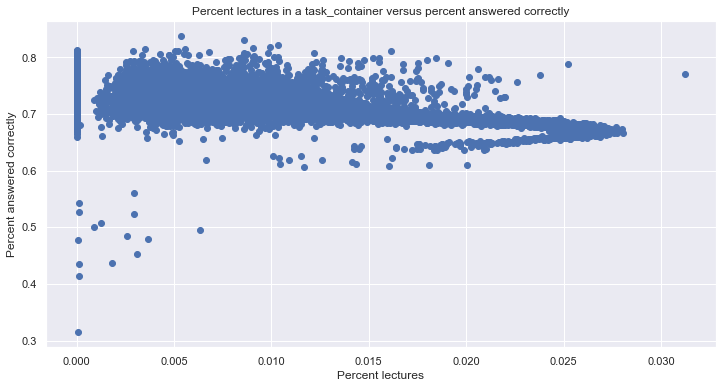

In [88]:
batch = batch_lect.iloc[:, 3:]

fig = plt.figure(figsize = (12, 6))
plt.title("Percent lectures in a task_container versus percent answered correctly")
plt.xticks(rotation=0)
plt.xlabel("Percent lectures")
plt.ylabel("Percent answered correctly")

x = batch['Percent_lecture']
y = batch['Percent_correct']
plt.scatter(x, y, marker='o')
plt.show()

The last thing that I want to check is if having a lecture in a batch helps. As you can see, it does not. Batches without lectures have about 8% more correct answers than batches with lectures.

In [89]:
batch_lect['Has_lecture'] = np.where(
                                     batch_lect['Lecture'] == 0, 
                                     False, 
                                     True
                                    )

print(f'We have {batch_lect[batch_lect.Has_lecture == True].shape[0]} task_container_ids with lectures ' \
      f'and {batch_lect[batch_lect.Has_lecture == False].shape[0]} task_container_ids without lectures.')

We have 9369 task_container_ids with lectures and 631 task_container_ids without lectures.


In [90]:
batch_lect = batch_lect[['Num_of_Wrong', 
                         'Num_of_Right', 
                         'Has_lecture']]
batch_lect = batch_lect.groupby("Has_lecture"). \
                        sum()
batch_lect['Percent_correct'] = batch_lect['Num_of_Right'] / \
                                    (batch_lect['Num_of_Wrong'] + \
                                     batch_lect['Num_of_Right'])
batch_lect = batch_lect[['Percent_correct']]

batch_lect

Percent_correct
Has_lecture                 
False               0.736412
True                0.657087

---

### Exploring Example Test. Stage 1.

**example_test_rows.csv**:

Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

* PRIOR_GROUP_RESPONSES (str) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

* PRIOR_GROUP_ANSWER_CORRECT (str) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.

In [91]:
bold('**Shape of our example test:**')
display(example_test.shape)

**Shape of our example test:**

(104, 11)

In [92]:
example_test.head(10)

row_id  group_num    timestamp     user_id  content_id  content_type_id  \
0       0          0            0   275030867        5729                0   
1       1          0  13309898705   554169193       12010                0   
2       2          0   4213672059  1720860329         457                0   
3       3          0  62798072960   288641214       13262                0   
4       4          0  10585422061  1728340777        6119                0   
5       5          0  18020362258  1364159702       12023                0   
6       6          0   2325432079  1521618396         574                0   
7       7          0  39456940781  1317245193       12043                0   
8       8          0   3460555189  1700555100        7910                0   
9       9          0   2214770464   998511398        7908                0   

   task_container_id  prior_question_elapsed_time  \
0                  0                          NaN   
1               4427                      19000.0   
2                240                      17000.0   
3                266                      23000.0   
4                162                      72400.0   
5               4424                      18000.0   
6               1367                      18000.0   
7               5314                      17000.0   
8                532                      21000.0   
9                393                      21000.0   

  prior_question_had_explanation prior_group_answers_correct  \
0                            NaN                          []   
1                           True                         NaN   
2                           True                         NaN   
3                           True                         NaN   
4                           True                         NaN   
5                           True                         NaN   
6                           True                         NaN   
7                           True                         NaN   
8                           True                         NaN   
9                           True                         NaN   

  prior_group_responses  
0                    []  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                   NaN

In [93]:
batches_test = set(
                   list(
                        example_test['task_container_id'].unique()
                        )
                  )
batches_train = set(
                    list(
                         data['task_container_id'].unique()
                         )
                   )

print(f'All batches in example_test are also in train is {batches_test.issubset(batches_train)}.')

All batches in example_test are also in train is True.


Kaggle says that there are new users in the test set, but let's check this anyway with example_test. As we can see, there is a new user in example_test indeed.

In [94]:
user_test = set(
                list(
                     example_test['user_id'].unique()
                     )
                )
user_train = set(
                 list(
                      data['user_id'].unique()
                     )
                )

print(f'User_ids in example_test but not in train: {user_test - user_train}.')

User_ids in example_test but not in train: {275030867}.


---